# Time Series Forecasting (ARIMA and SARIMAX)

# Modules

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
from datetime import timedelta, date
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from PIL import Image
from io import BytesIO

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

# Read the Dataset

Source: https://www.kaggle.com/code/sercanyesiloz/electricity-production-forecasting-arima/input

In [ ]:
df = pd.read_csv('/content/Electric_Production.csv', parse_dates=['DATE'])
df.set_index('DATE', inplace=True) # Make the DATE's value as an index, lag, or t
df

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


This dataset has 397 rows in total and contains 2 columns, DATE, and Value, transforming the DATE's value into an index would allow us to easily access and manipulate data points based on the specific periods.


# Exploratory Data Analysis

Let's find some useful information or insights so that understand more about the characteristics of the original dataset.

## Basic Analysis

In [ ]:
df.isnull().any()

Value    False
dtype: bool

In [ ]:
df['Value'].dtype

dtype('float64')

In [ ]:
df.index.min(), df.index.max()

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

In [ ]:
df.describe()

,Value
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


## Plot Analysis

Before doing the analysis any further, we should plot the original dataset for the precept to do the time series analysis.

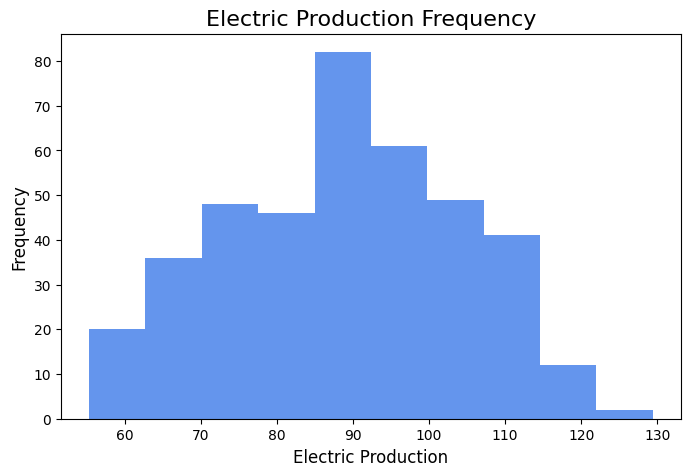

In [ ]:
# Electric Production Frequency
plt.figure(figsize = (8,5))
plt.hist(df['Value'], color = 'cornflowerblue')
plt.xlabel('Electric Production', size = 12)
plt.ylabel('Frequency', size = 12)
plt.title('Electric Production Frequency', size = 16)
plt.show()

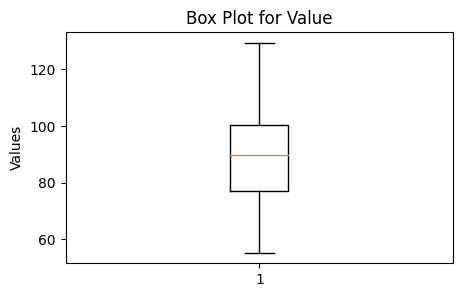

In [ ]:
# Find the outlier
plt.figure(figsize=(5, 3))
plt.boxplot(df)
plt.title('Box Plot for Value')
plt.ylabel('Values')
plt.show()

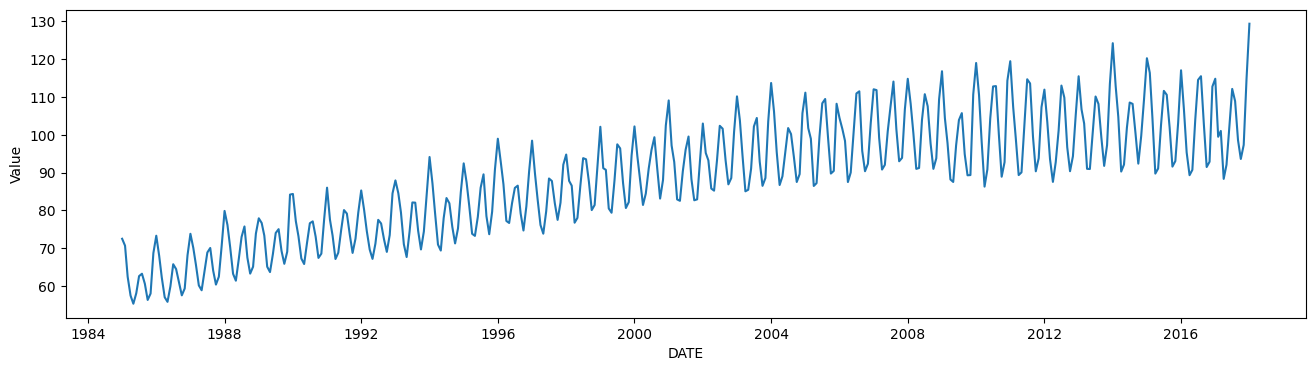

In [ ]:
# Plot the original data movement over time
plt.figure(figsize=(16, 4))
sns.lineplot(data=df, x=df.index,y=df.Value)
plt.show()

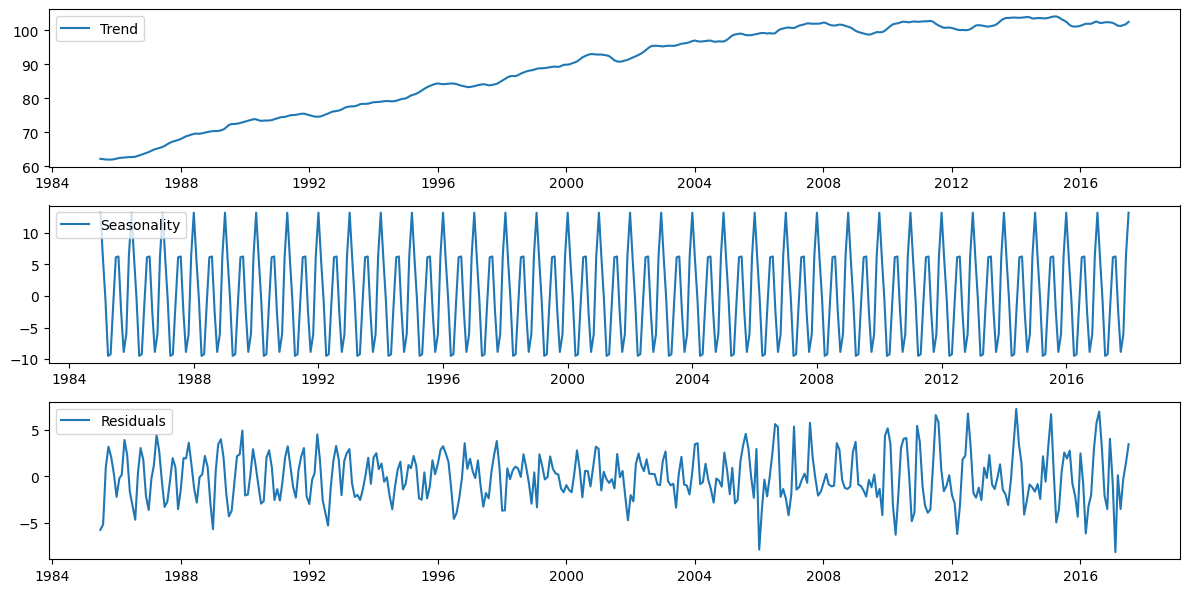

In [ ]:
# Do the decomposition
decomposition = sm.tsa.seasonal_decompose(df['Value'], model='additive')

# Decomposition components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(12, 8))
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

From the seasonal component, the data has a pattern every 1 year or 12 months.

In [ ]:
# Rolling statistics
# Computes the data mean based on the 12 previous data point
df['rollMean'] = df.Value.rolling(window=12).mean()
df['rollStd'] = df.Value.rolling(window=12).std()

<Axes: xlabel='DATE', ylabel='Value'>

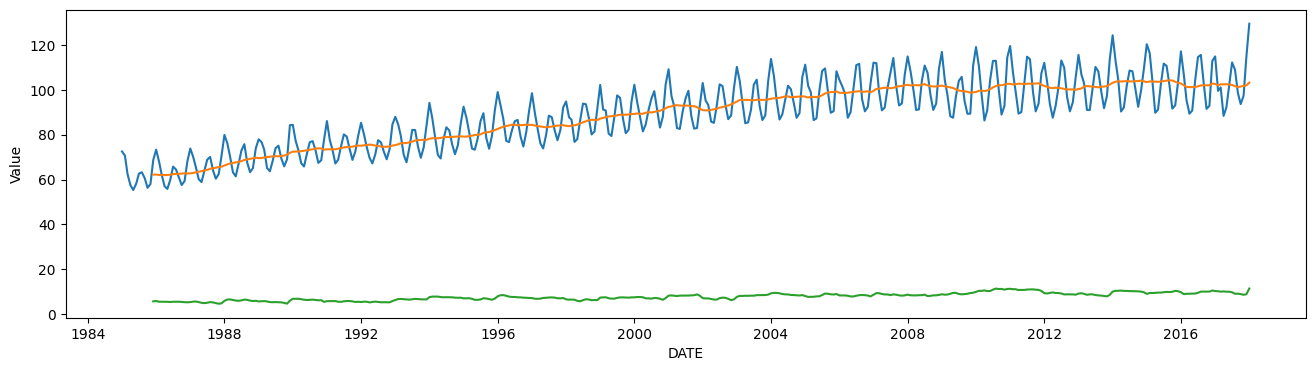

In [ ]:
# Plot the rolling statistics
plt.figure(figsize = (16,4))
sns.lineplot(data=df, x=df.index, y=df.Value)
sns.lineplot(data=df, x=df.index, y=df.rollMean)
sns.lineplot(data=df, x=df.index, y=df.rollStd)

Based on the visualization, the rolling mean shows a clear upward and slightly unstable std pattern movement over time. It suggests non-stationary.

# Stationarity Test with Dickey-Fuller Test

The ADF test is used to assess whether a time series is stationary or non-stationary. Stationarity means that the statistical properties of a time series, such as its mean and variance, remain constant over time. Non-stationarity indicates that these properties change over time.

Null hypothesis = Non-stationary

In [ ]:
adfTest = adfuller(df['Value'],autolag = "AIC",) # Use AIC for choosing the number of lags
adfTest

(-2.256990350047235,
 0.1862146911658712,
 15,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 1840.8474501627156)

In [ ]:
stats = pd.Series(adfTest[0:4],index=['Test Statistic', 'p-value','#lags used','number of observations used'])
stats

Test Statistic                  -2.256990
p-value                          0.186215
#lags used                      15.000000
number of observations used    381.000000
dtype: float64

Failed to reject the null hypothesis since the p-value is bigger than 0.05. Then, the data does not achieve the stationarity.

# Dickey-Fuller Test (Time Shift Differencing and Log)

Transforms the data to achieve stationarity with time shift differencing and log

In [ ]:
# Build the function for each method
def test_stationarity(df, Value):
    df = df.copy()
    df.loc[:, 'rollMean'] = df[Value].rolling(window=12).mean()
    df.loc[:, 'rollStd'] = df[Value].rolling(window=12).std()

    adfTest = adfuller(df[Value], autolag='AIC')
    stats = pd.Series(adfTest[0:4], index=['Test Statistic', 'p-value', '#lags used', 'number of observationis used'])
    print(stats)

    for key, values in adfTest[4].items():
        print('criticality', key, ':', values)

    sns.lineplot(data=df, x=df.index, y=Value)
    sns.lineplot(data=df, x=df.index, y='rollMean')
    sns.lineplot(data=df, x=df.index, y='rollStd')

## Time Shift Differencing

In [ ]:
# Using Time shift Differencing
df['Shift'] = df.Value.shift()
df['shiftDiff'] = df['Value'] - df['Shift']
df.head()

,Value,rollMean,rollStd,Shift,shiftDiff
DATE,,,,,
1985-01-01,72.5052,NaN,NaN,NaN,NaN
1985-02-01,70.6720,NaN,NaN,72.5052,-1.8332
1985-03-01,62.4502,NaN,NaN,70.6720,-8.2218
1985-04-01,57.4714,NaN,NaN,62.4502,-4.9788
1985-05-01,55.3151,NaN,NaN,57.4714,-2.1563


Test Statistic                 -6.998284e+00
p-value                         7.435144e-10
#lags used                      1.400000e+01
number of observationis used    3.710000e+02
dtype: float64
criticality 1% : -3.4480996560263386
criticality 5% : -2.8693621113224137
criticality 10% : -2.570937038891028


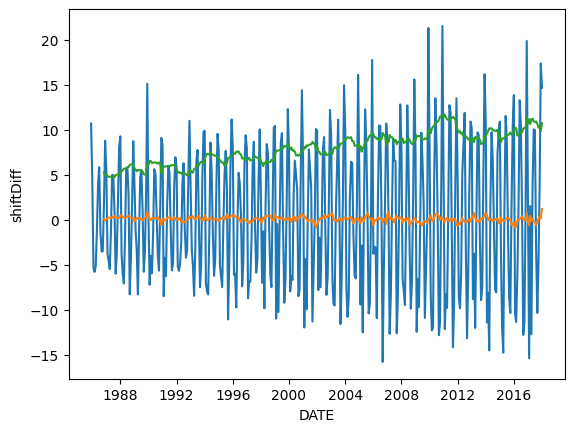

In [ ]:
test_stationarity(df.dropna(),'shiftDiff')

p-value still bigger than 0.05

## Log

In [ ]:
#log
log_df = df[['Value']].copy()
log_df['log'] = np.log(log_df['Value'])
log_df

,Value,log
DATE,,
1985-01-01,72.5052,4.283658
1985-02-01,70.6720,4.258049
1985-03-01,62.4502,4.134369
1985-04-01,57.4714,4.051287
1985-05-01,55.3151,4.013046
...,...,...
2017-09-01,98.6154,4.591227
2017-10-01,93.6137,4.539177
2017-11-01,97.3359,4.578168


In [ ]:
log_df.isnull().any()

Value    False
log      False
dtype: bool

Test Statistic                   -3.145360
p-value                           0.023373
#lags used                       15.000000
number of observationis used    381.000000
dtype: float64
criticality 1% : -3.4476305904172904
criticality 5% : -2.869155980820355
criticality 10% : -2.570827146203181


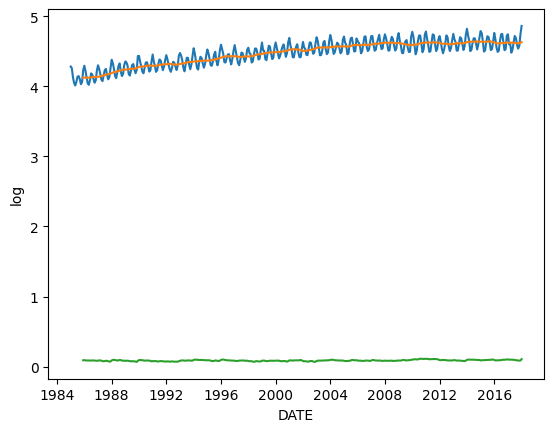

In [ ]:
test_stationarity(log_df,'log')

p-value < 0.05. Achieved!

Use log_df for analysis

In [ ]:
log_df

,Value,log
DATE,,
1985-01-01,72.5052,4.283658
1985-02-01,70.6720,4.258049
1985-03-01,62.4502,4.134369
1985-04-01,57.4714,4.051287
1985-05-01,55.3151,4.013046
...,...,...
2017-09-01,98.6154,4.591227
2017-10-01,93.6137,4.539177
2017-11-01,97.3359,4.578168


# Determining the (p, d, q) Parameter's Order

p = Autoregressive Order (based on PACF)

d = Differencing order

q = Moving Average Order (based on ACF)

## Autocorrelation Function and Partial Autocorrelation Function

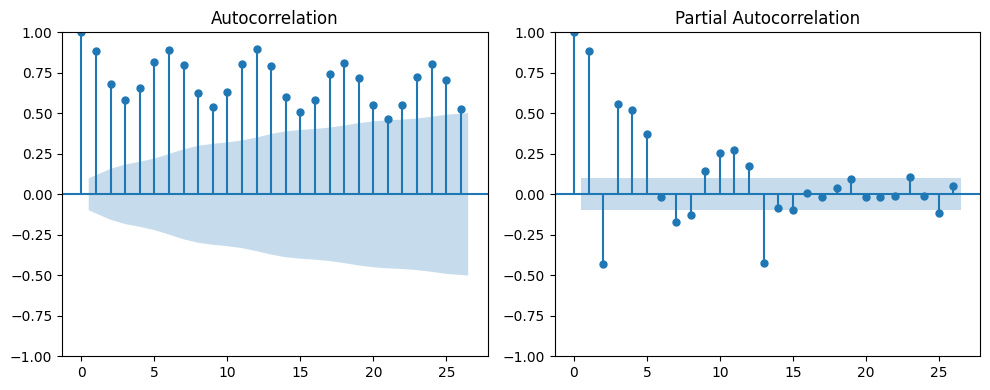

In [ ]:
# Plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plot_acf(log_df['log'], ax=ax1)

# Plot the Partial Autocorrelation Function (PACF)
ax2 = plt.subplot(122)
plot_pacf(log_df['log'], ax=ax2)

plt.tight_layout()
plt.show()

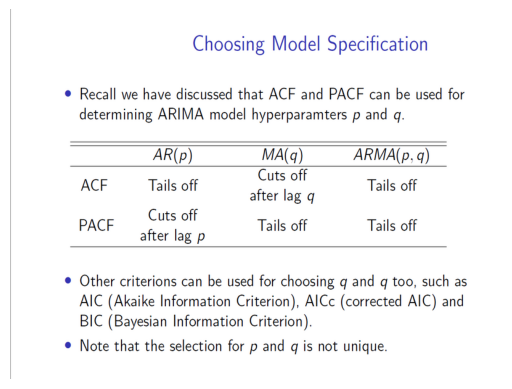

In [ ]:
image_url = "https://drive.google.com/uc?export=download&id=1rCIpCv3MwjAcKNPv7PrfB-NCLn9UcmI4"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
width, height = 800, 600
img = img.resize((width, height), Image.LANCZOS)
plt.imshow(img)
plt.axis('off')
plt.show()

Source: University of Pittsburgh

ACF = Tails off

PACF = Cut off  (ACF should be 1 or 2)

## Manual Test

Since the selection for p and q is not unique. Try to test which AIC and BIC scores are lower and higher for the Likelihood score

For integrated (d) value, use 1 due to transforming the original data set once (log)

In [ ]:
log_df.index = pd.to_datetime(log_df.index)
log_df = log_df.asfreq('MS')
ar_model = ARIMA(log_df['log'], order=(2,1,2)).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    log   No. Observations:                  397
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 754.803
Date:                Sun, 01 Oct 2023   AIC                          -1499.606
Time:                        16:05:55   BIC                          -1479.699
Sample:                    01-01-1985   HQIC                         -1491.719
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.001    984.991      0.000       0.997       1.001
ar.L2         -0.9998      0.000  -3735.875      0.000      -1.000      -0.999
ma.L1         -1.0338      0.068    -15.190      0.000      -1.167      -0.900
ma.L2          0.9986      0.127      7.876      0.000       0.750       1.247
sigma2         0.0013      0.000      7.221      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   6.59   Jarque-Bera (JB):                 8.06
Prob(Q):                              0.01   Prob(JB):                         0.02
Heteroskedasticity (H):               1.19   Skew:                             0.07
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARIMA and SARIMAX

## Train and Test the Model

Use the last 12 data points as a test

In [ ]:
print(log_df.shape)
train=log_df['log'].iloc[:-12]
test=log_df['log'].iloc[-12:]
print(train.shape, test.shape)

(397, 2)
(385,) (12,)


In [ ]:
print(test.index, train.index)

DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01'],
              dtype='datetime64[ns]', name='DATE', freq='MS') DatetimeIndex(['1985-01-01', '1985-02-01', '1985-03-01', '1985-04-01',
               '1985-05-01', '1985-06-01', '1985-07-01', '1985-08-01',
               '1985-09-01', '1985-10-01',
               ...
               '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01'],
              dtype='datetime64[ns]', name='DATE', length=385, freq='MS')


Create models

In [ ]:
test_df = test.to_frame()
train_df = train.to_frame()

In [ ]:
# ARIMA
order = (2, 1, 2)  # Order (p, d, q)
model = sm.tsa.ARIMA(train, order=order)
results = model.fit()

# Calculate the length of train and test data
start = len(train)
end = len(train) + len(test) - 1

pred_arima = results.predict(start=start, end=end, typ='levels')

# Convert predictions into appropriate indices
pred_arima.index = log_df.index[start:end + 1]
# print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
order = (2, 1, 2)
seasonal_order = (2, 1, 2, 12)  # Seasonal order (P, D, Q, m)
model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order)
results = model.fit()

start = len(train)
end = len(train) + len(test) - 1

pred_sarimax = results.predict(start=start, end=end, typ='levels')

# Convert predictions into appropriate indices
pred_sarimax.index = log_df.index[start:end + 1]
# print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


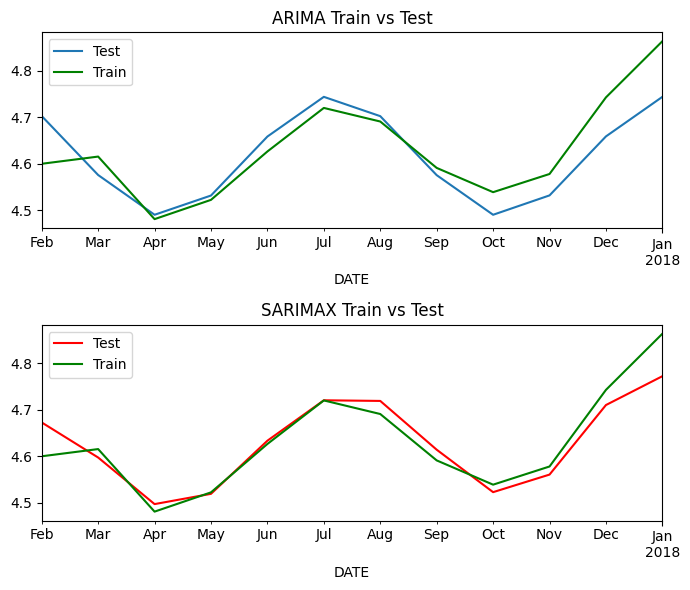

In [ ]:
# Visualize ARIMA train and test
plt.figure(figsize=(7, 6))
plt.subplot(2, 1, 1)
pred_arima.plot(legend=True, label='Test')
test_df['log'].plot(legend=True, label='Train', color='green')
plt.title('ARIMA Train vs Test')

# Visualize SARIMAX train and test
plt.subplot(2, 1, 2)
pred_sarimax.plot(legend=True, label='Test', color='red')
test_df['log'].plot(legend=True, label='Train', color='green')
plt.title('SARIMAX Train vs Test')

plt.tight_layout()
plt.show()

 Evaluate the performance of predictive models

In [ ]:
rmse = sqrt(mean_squared_error(test_df['log'], pred_arima))
print(f'RMSE for ARIMA: {rmse}')

rmse = sqrt(mean_squared_error(test_df['log'], pred_sarimax))
print(f'RMSE for SARIMAX: {rmse}')

RMSE for ARIMA: 0.05766039343233465
RMSE for SARIMAX: 0.037797961777540724


SARIMAX has better score results (indicates less prediction errors)



Forecast future values (12 months ahead)

In [ ]:
# Set entire log of observations as a train data
train_log = log_df['log']
train_log

DATE
1985-01-01    4.283658
1985-02-01    4.258049
1985-03-01    4.134369
1985-04-01    4.051287
1985-05-01    4.013046
                ...   
2017-09-01    4.591227
2017-10-01    4.539177
2017-11-01    4.578168
2017-12-01    4.742505
2018-01-01    4.862945
Freq: MS, Name: log, Length: 397, dtype: float64

## ARIMA Forecast

In [ ]:
# Fit the ARIMA model to the log-transformed data
model_arima = ARIMA(train_log, order=(2, 1, 2))
model = model_arima.fit()

# Get the forecasts from the ARIMA model in log-transformed units
forecast_log_arima = model.forecast(steps=12)

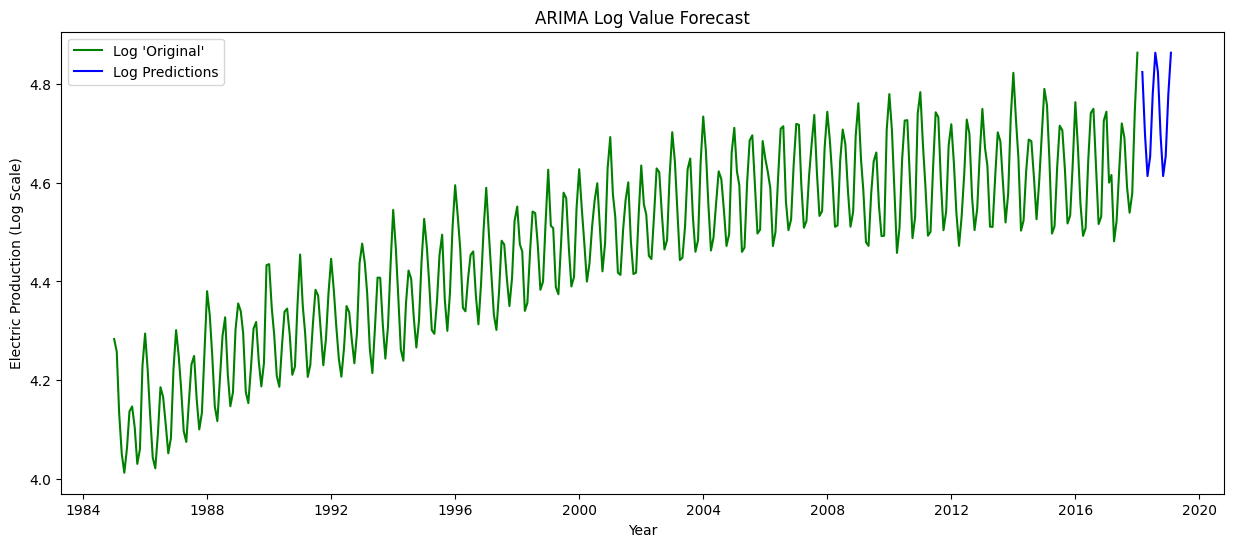

In [ ]:
model_arima = ARIMA(train_log, order=(2, 1, 2))
model = model_arima.fit()

# Extend the time index for predictions
future_index = pd.date_range(start=log_df.index[-1], periods=13, freq='M')

# Visualize the original time series (log) and the predictions
plt.figure(figsize=(15, 6))
plt.plot(log_df.index, log_df['log'], label="Log 'Original'", color='green')
plt.plot(future_index[1:], forecast_log_arima, color='blue', label='Log Predictions')
plt.xlabel('Year')
plt.ylabel('Electric Production (Log Scale)')
plt.title('ARIMA Log Value Forecast')
plt.legend()
plt.show()

In [ ]:
# ARIMA future log value forecast
forecast_log_arima

2018-02-01    4.823830
2018-03-01    4.699011
2018-04-01    4.613388
2018-05-01    4.652622
2018-06-01    4.777436
2018-07-01    4.862936
2018-08-01    4.823584
2018-09-01    4.698775
2018-10-01    4.613398
2018-11-01    4.652868
2018-12-01    4.777672
2019-01-01    4.862925
Freq: MS, Name: predicted_mean, dtype: float64

## SARIMAX Forecast

In [ ]:
# Fit the SARIMAX model to the log-transformed data
sarimax_model = SARIMAX(train_log, order=(2, 1, 2), seasonal_order=(2, 1, 2, 12))
fitted_model = sarimax_model.fit()

# Get the forecasts from the SARIMAX model in log-transformed units
forecast_log_sarimax = fitted_model.forecast(steps=12)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


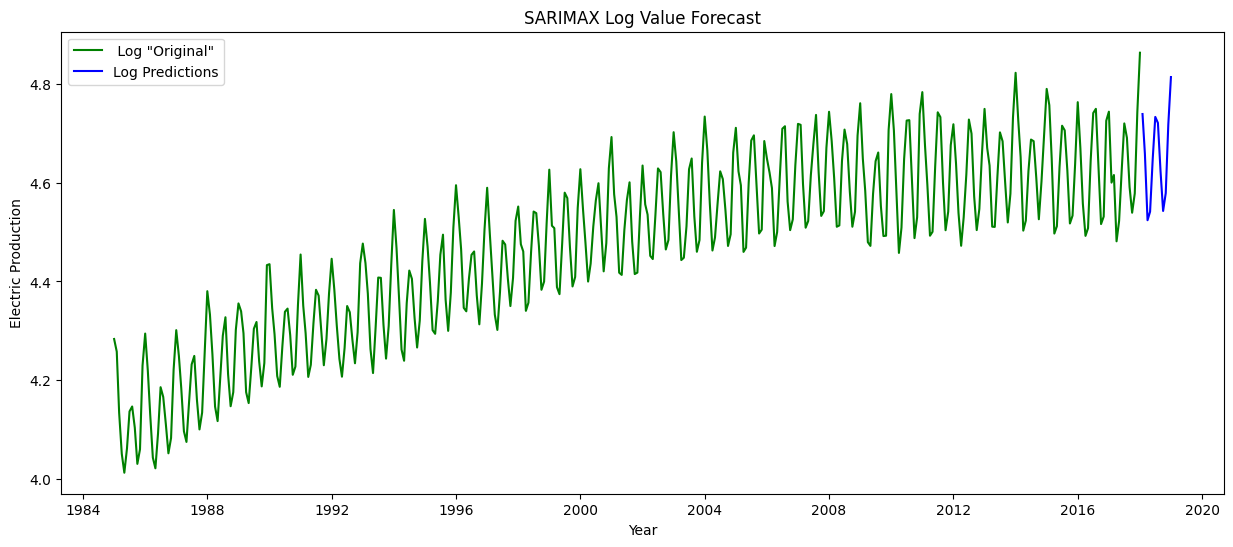

In [ ]:
# Predictions
predictions_SARIMAX = fitted_model.get_forecast(steps=len(test))

# Confidence intervals for the predictions
pred_confidence = predictions_SARIMAX.conf_int()

# Extend the time index for predictions
future_index = pd.date_range(start=log_df.index[-1], periods=len(test), freq='M')

# Visualize the original time series (log) and the predictions
plt.figure(figsize=(15, 6))
plt.plot(log_df.index, log_df['log'], label=' Log "Original"', color='green')
plt.plot(future_index, predictions_SARIMAX.predicted_mean, color='blue', label='Log Predictions')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('SARIMAX Log Value Forecast')
plt.legend()
plt.show()

In [ ]:
# SARIMAX future log value forecast
forecast_log_sarimax

2018-02-01    4.738903
2018-03-01    4.658522
2018-04-01    4.524040
2018-05-01    4.541340
2018-06-01    4.648149
2018-07-01    4.733066
2018-08-01    4.720922
2018-09-01    4.622512
2018-10-01    4.542756
2018-11-01    4.578839
2018-12-01    4.717507
2019-01-01    4.813708
Freq: MS, Name: predicted_mean, dtype: float64

## Data Transformation

Turn the log into the original value

In [ ]:
forecast_arima_original = np.exp(forecast_log_arima)
forecast_sarimax_original = np.exp(forecast_log_sarimax)

In [ ]:
# SARIMAX original forecast value
forecast_sarimax_original

2018-02-01    114.308770
2018-03-01    105.480066
2018-04-01     92.207340
2018-05-01     93.816401
2018-06-01    104.391530
2018-07-01    113.643464
2018-08-01    112.271775
2018-09-01    101.749260
2018-10-01     93.949382
2018-11-01     97.401239
2018-12-01    111.889007
2019-01-01    123.187538
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
# ARIMA original forecast value
forecast_arima_original

2018-02-01    124.440821
2018-03-01    109.838519
2018-04-01    100.825176
2018-05-01    104.859536
2018-06-01    118.799326
2018-07-01    129.403519
2018-08-01    124.410136
2018-09-01    109.812540
2018-10-01    100.826203
2018-11-01    104.885407
2018-12-01    118.827405
2019-01-01    129.402162
Freq: MS, Name: predicted_mean, dtype: float64

# Conclusion

## Comparison

Use Mean Absolut Error (MAE) and Root Mean Squared Error (RMSE) to test

In [ ]:
# ARIMA
rmse1 = sqrt(mean_squared_error(forecast_arima_original, pred_arima))
mae_arima = mean_absolute_error(forecast_arima_original, pred_arima)
print('RMSE score:',rmse1)
print('MAE score:',mae_arima)

RMSE score: 110.55237849926985
MAE score: 110.07702334955962


In [ ]:
# SARIMAX
rmse2 = sqrt(mean_squared_error(forecast_sarimax_original, pred_sarimax))
mae_sarimax = mean_absolute_error(forecast_sarimax_original, pred_sarimax)
print('RMSE score:',rmse2)
print('MAE score:',mae_sarimax)

RMSE score: 101.16372685621886
MAE score: 100.72969966079638


Lower MAE and RMSE is better, which is SARIMAX

## Result

In [ ]:
# Convert the Series to a 1-dimensional array using .values or .to_numpy()
predicted_value_sarimax_array = forecast_sarimax_original.values.ravel()

predicted_value = pd.DataFrame({
    'Date': forecast_sarimax_original.index,
    'predicted_value': predicted_value_sarimax_array
})

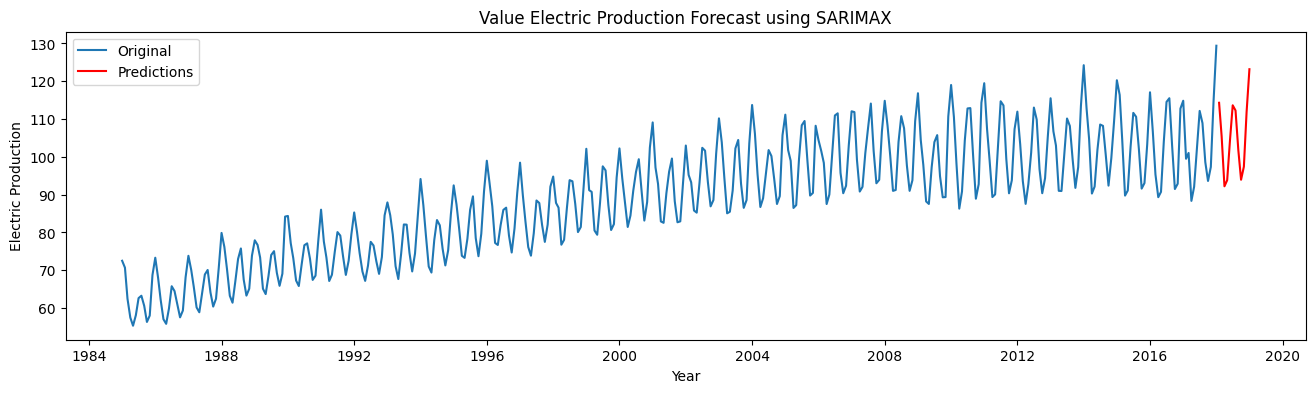

In [ ]:
# Final Result Visualization
plt.figure(figsize=(16, 4))
plt.plot(log_df['Value'], label='Original')
plt.plot(future_index, forecast_sarimax_original, color='red', label='Predictions')
plt.xlabel('Year')
plt.ylabel('Electric Production')
plt.title('Value Electric Production Forecast using SARIMAX')
plt.legend()
plt.show()

In [ ]:
predicted_value

,Date,predicted_value
0,2018-02-01,114.308770
1,2018-03-01,105.480066
2,2018-04-01,92.207340
3,2018-05-01,93.816401
4,2018-06-01,104.391530
5,2018-07-01,113.643464
6,2018-08-01,112.271775
7,2018-09-01,101.749260
8,2018-10-01,93.949382
9,2018-11-01,97.401239


# Limitations

**Convergence (converged : false)**

The objective function value did not reach a minimum or maximum within the specified constraints or tolerance levels. This may require further investigation and potentially adjustments to the optimization algorithm or problem formulation to improve convergence.

In [ ]:
results.mle_retvals # When fitting the model

{'fopt': -2.231159764910974, 'gopt': array([-0.00082705, -0.00202302,  0.00063842, -0.00182283,  0.00178561,
       -0.00163226,  0.00416011, -0.00223236,  0.01463344]), 'fcalls': 810, 'warnflag': 1, 'converged': False, 'iterations': 50}
